In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as mn

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(display='diagram')

#Nate shared this list as his ultimate go-to during our regresssion hack-a-thon

In [2]:
df_ames_train = pd.read_csv('./datasets/train.csv')

In [3]:
df_ames_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df_ames_train.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


I see these features have missing data: Lot Frontage, and Mas Vnr Area.  There may be more that I find since I can't see all my features in this output.

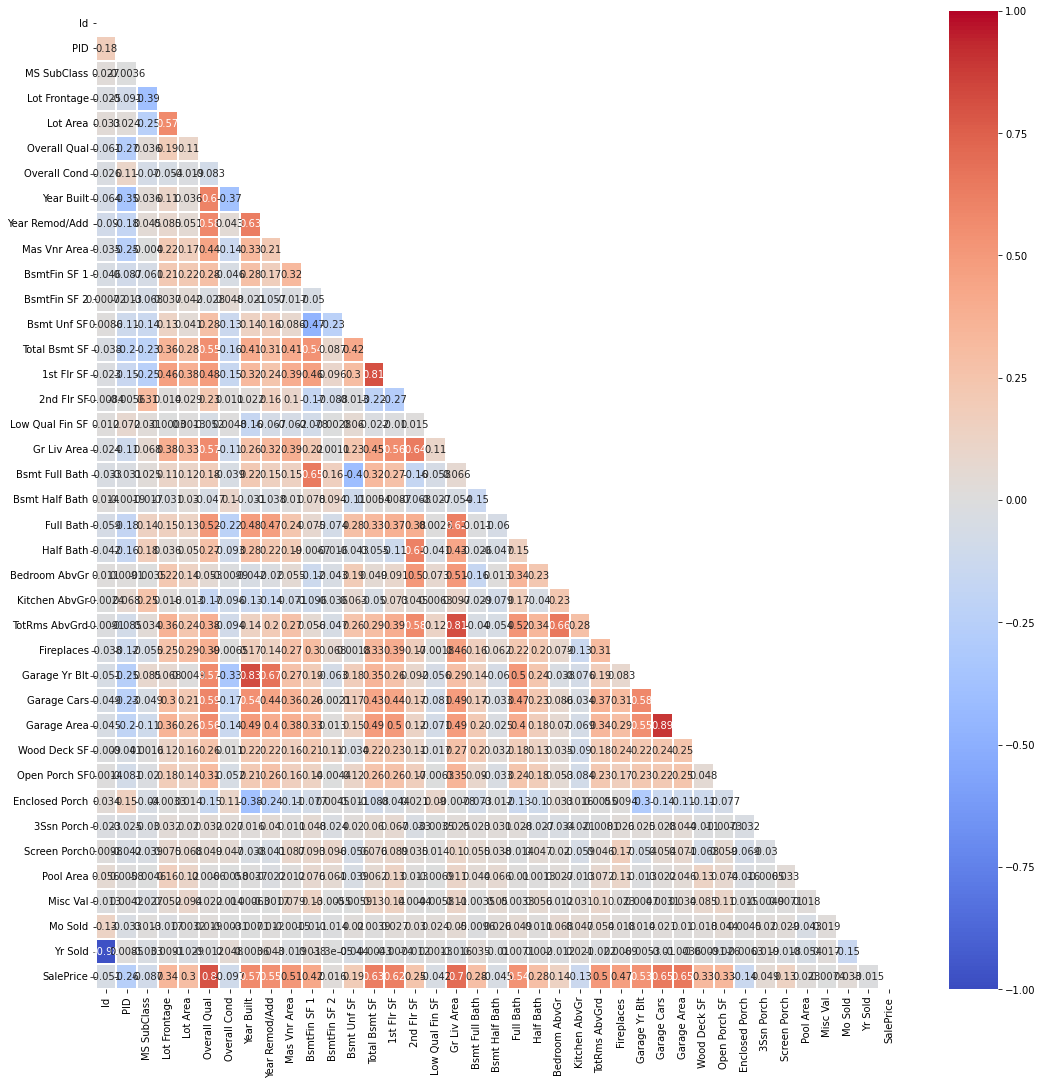

In [5]:
#mask created by jeff, taken from lessons
#shared by Nate during regression hack-a-thon
mask = np.zeros_like(df_ames_train.corr())
mask[np.triu_indices_from(mask)] = True

# # inspiration for heatmap parameters comes from jeff's work
plt.figure(figsize=(18,18))

sns.heatmap(
     df_ames_train.corr(),
     cmap='coolwarm',
     annot=True,
     mask=mask,
     vmin=-1.,
     vmax=1.,
     linewidths=.01,
     center=0
 );

<AxesSubplot:>

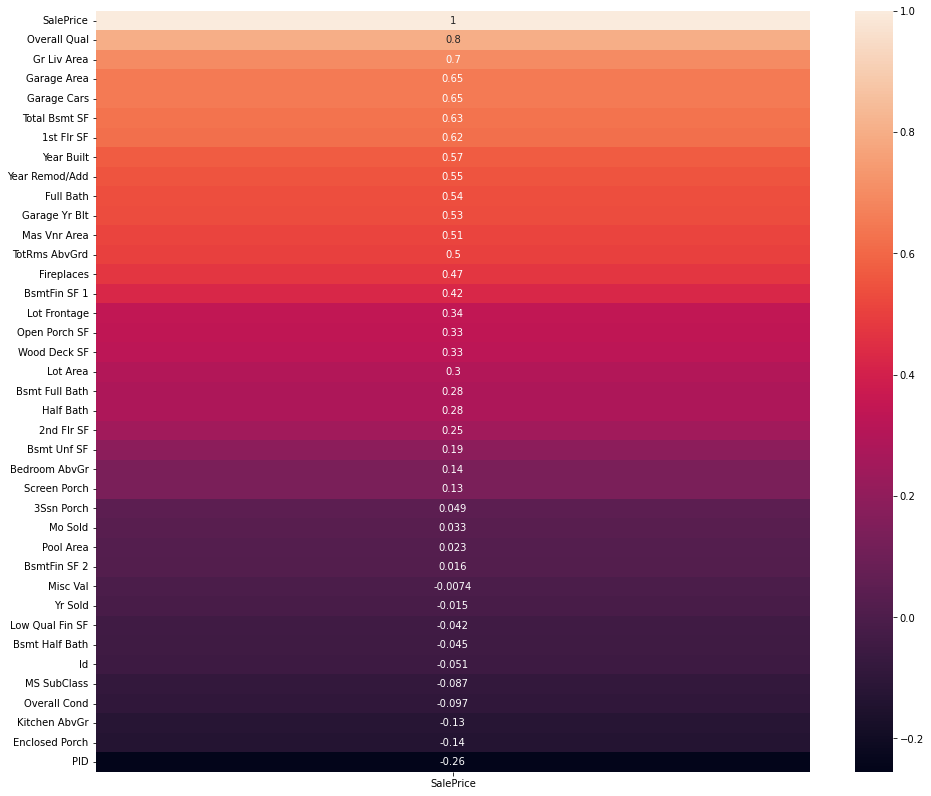

In [6]:
plt.figure(figsize=(16,14))

sns.heatmap(
    df_ames_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False),
    annot=True
)

After looking at the correlation matrix above, I am choosing a pared-down version of the dataset for my analysis, basically choosing features that have a correlation of .54 and higher to SalePrice.

In [7]:
df_mini = df_ames_train[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
     'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath', 'SalePrice']]

In [8]:
df_mini.head(2)

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,SalePrice
0,6,1479,475.0,2.0,725.0,725,1976,2005,2,130500
1,7,2122,559.0,2.0,913.0,913,1996,1997,2,220000


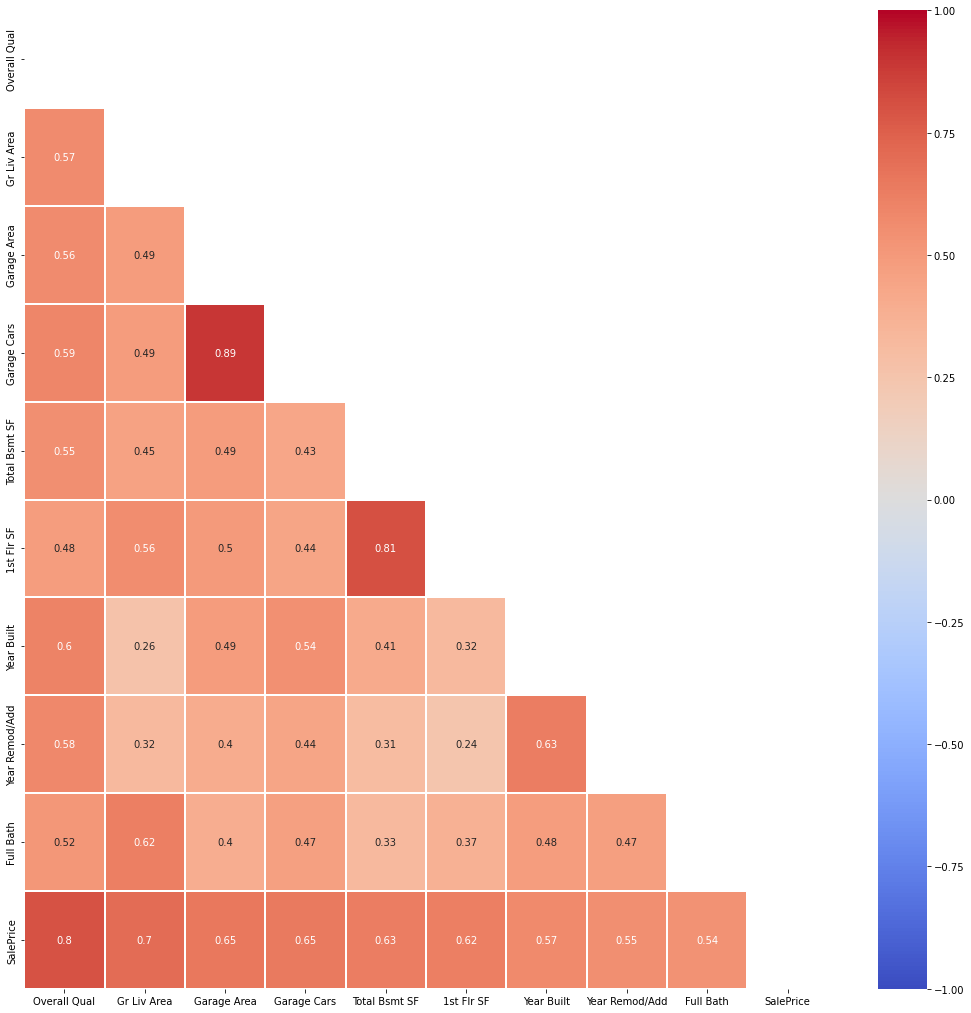

In [9]:
#need to check for multicollinearity among variables
#mask created by jeff, taken from lessons
#shared by Nate during regression hack-a-thon
#Adapted to look at a subset of predictor variables for Ames data
mask = np.zeros_like(df_mini.corr())
mask[np.triu_indices_from(mask)] = True

# # inspiration for heatmap parameters comes from jeff's work
plt.figure(figsize=(18,18))

sns.heatmap(
     df_mini.corr(),
     cmap='coolwarm',
     annot=True,
     mask=mask,
     vmin=-1.,
     vmax=1.,
     linewidths=.01,
     center=0
 );

I see here that Full Bath has a correlation of .62 with Gr Liv Area, so I don't need both in the model. Gr Liv Area has a higher correlation with SalePrice so I will drop Full Bath later in my Linear Regression Modeling Tweaking.  I also know that Garage Area and Garage Cars are representing the same information and I shouldn't include both in my model.  Their correlation with each other is .89 compared to both having the same correlation of .65 to SalePrice.  I decide to keep Garage Cars for later models because it's easier for people to picture a 1-car vs a 2-car garage when I am explaining the model.  If I had "sat with the data" long enough here, I would have noticed high correlations between two other sets of features!  Total Bsmt SF and 1st Flr SF have a correlation of .81 with each other, but only .63 and .62, respectively, with SalePrice.  I should keep Total Bsmt SF in the model because it is slightly more correlated with SalePrice and drop 1st Flr SF because there's obviously mulit-collinearity there.  The next set of features that are highly correlated with each other are Year Built and Year Remod/Add with a correlation of .63. Their correlations with SalePrice are .57 and .55 respectively, so Year Built should be kept in the model and Year Remod/Add should be dropped.

In [10]:
df_ames_train.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
Length: 81, dtype: int64

<AxesSubplot:>

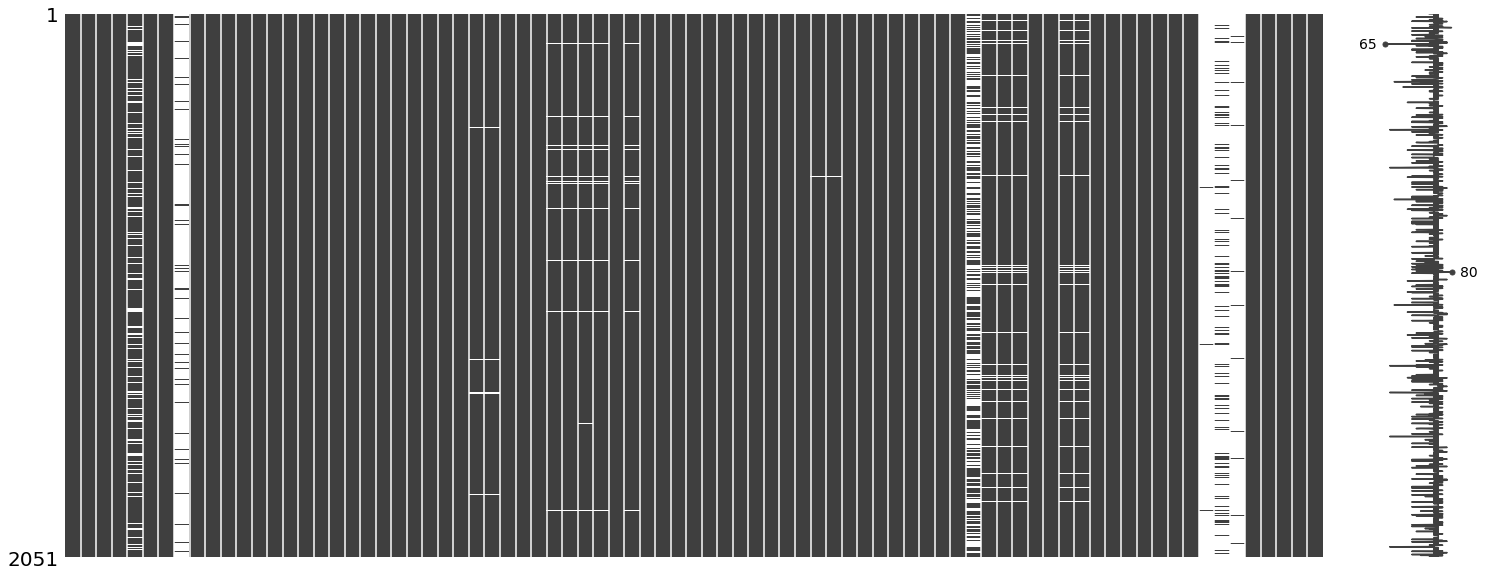

In [11]:
#Look at the pattern of missing values across our data
import missingno as mn

mn.matrix(df_ames_train)

#Nate shared this code with me.  I knew we saw it in class, and searched my lessons
#but couldn't find it so I asked him for it.

This is great to see - no clumps of missing data focused in rows.  

<AxesSubplot:>

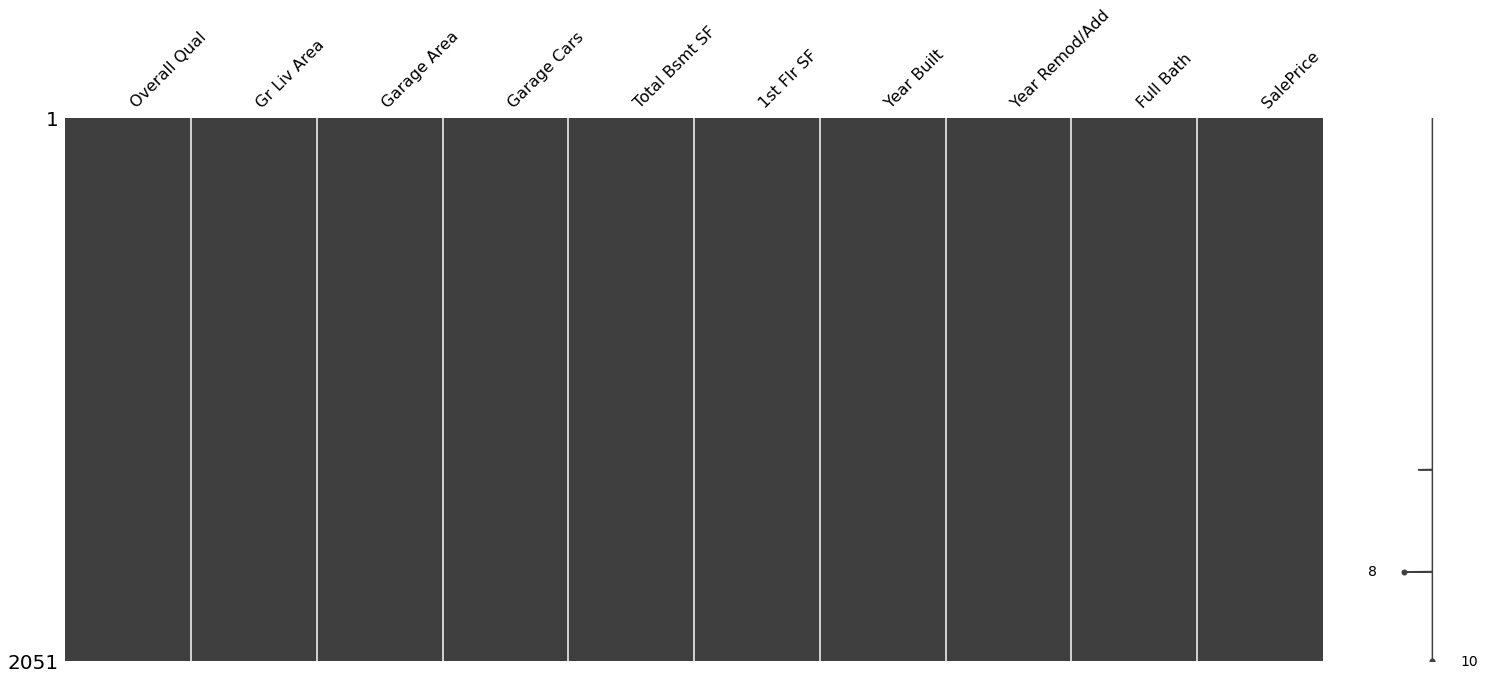

In [12]:
mn.matrix(df_mini)

I created my mini dataset by simply focusing on the top 9 features that were the most highly correlated with Sale Price.

To take a stab at my first model to submit to Kaggle, I chose 3 features that logically seemed not to be highly correlated, although their actually correlation to each other was greater than .5.  The features I chose were Overall Quality (which rates the overall material and finish of the house), Garage Area (the size of the garage in square feet), and Total Basement (total square feet of basement area).  I became obsessed with the Overall Quality feature, and decided it was a categorical variable rather than a numric, and decided not to use it in the first submission to Kaggle model.

I know I need to split my data into train/test before I do any data transformations and build any models.

In [13]:
#Check for missing data
df_mini.isna().sum()

Overall Qual      0
Gr Liv Area       0
Garage Area       1
Garage Cars       1
Total Bsmt SF     1
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
SalePrice         0
dtype: int64

In [14]:
#I'm okay with dropping this missing data

df_mini.dropna(inplace=True)

C:\Users\sarah\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [15]:
df_mini.isna().sum()


Overall Qual      0
Gr Liv Area       0
Garage Area       0
Garage Cars       0
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
SalePrice         0
dtype: int64

In [16]:
#this tells me I only dropped 2 rows and I'm okay with that!
df_mini.describe()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,SalePrice
count,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,6.113714,1499.464129,473.766227,1.776964,1058.084919,1164.727672,1971.745242,1984.199610,1.577355,181534.626159
std,1.425991,500.461893,215.944850,0.764531,449.498894,396.565535,30.168060,21.030407,0.549320,79262.113026
min,1.000000,334.000000,0.000000,0.000000,0.000000,334.000000,1872.000000,1950.000000,0.000000,12789.000000
25%,5.000000,1130.000000,319.000000,1.000000,793.000000,879.000000,1954.000000,1965.000000,1.000000,129850.000000
50%,6.000000,1444.000000,480.000000,2.000000,995.000000,1093.000000,1974.000000,1993.000000,2.000000,162500.000000
75%,7.000000,1728.000000,576.000000,2.000000,1319.000000,1405.000000,2001.000000,2004.000000,2.000000,214000.000000
max,10.000000,5642.000000,1418.000000,5.000000,6110.000000,5095.000000,2010.000000,2010.000000,4.000000,611657.000000


In [17]:
#Ideally want to use Overall Qual but it is a categorical variable and I want to
#run a model so that I can submit to Kaggle
#X = df_mini[['Overall Qual', 'Garage Area', 'Total Bsmt SF']]
X = df_mini[['Garage Area', 'Total Bsmt SF']]
    

In [18]:
X.shape

(2049, 2)

In [19]:
y = df_mini['SalePrice']

In [20]:
y.shape

(2049,)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
lr = LinearRegression()

In [23]:
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
pd.DataFrame(lr.coef_.reshape(1, 2), columns=X.columns) 

,Garage Area,Total Bsmt SF
0,169.426765,71.425448


In [25]:
#Make predictions on the test set
preds = lr.predict(X_test)

In [26]:
#Evaluate my metrics
print('Linear Regression Model #1: MAE:', mean_absolute_error(y_test, preds))
print('Linear Regression Model #1: MSE:', mean_squared_error(y_test, preds))
print('Linear Regression Model #1: R2:', r2_score(y_test, preds))

Linear Regression Model #1: MAE: 36280.50756458365
Linear Regression Model #1: MSE: 2344237361.1137433
Linear Regression Model #1: R2: 0.5423823795908074


Wow!  What a bad model!  That MSE is huge!  R squared is okay but not great but ouch on that MSE!

In [27]:
#I want to look at some graphs of my residuals
residuals = preds - y_test

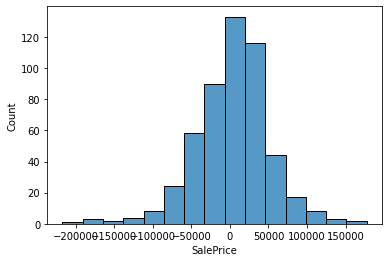

In [28]:
sns.histplot(residuals, bins=15);
#This looks like a normal distribution so this doesn't look too bad.

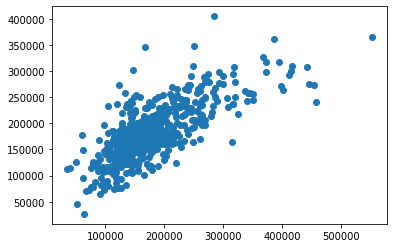

In [29]:
plt.scatter(y_test, preds);
#I see something close to a line here but I feel like it could be better.

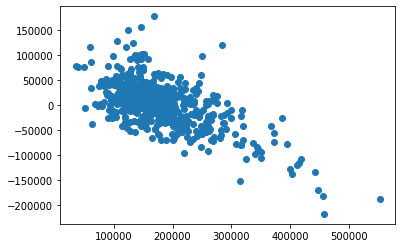

In [30]:
plt.scatter(y_test, residuals);
#There's a clustering in the top left hand side that makes me sad...I'd rather not see any pattern in this scatterplot

Create a Null (Baseline) model to compare to my Linear Regression model.  I will compare all models to this to make sure they are improvements over the simplest model.  Because I want to predict sales price, my gut tells me that I want to use the average sales price.  When I compare the average sales price to the median sales price, I see $181,469.70 vs. $162,500.  I'm completely comfortable using the mean sales price!

In [31]:
df_ames_train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [32]:
null_model_preds = np.full_like(y_test, y_train.mean())

In [33]:
#Evaluate metrics for the Baseline Model
print('Baseline Model #1: MAE:', mean_absolute_error(y_test, null_model_preds))
print('Baseline Model #1: MSE:', mean_squared_error(y_test, null_model_preds))
print('Baseline Model #1: R2:', r2_score(y_test, null_model_preds))



Baseline Model #1: MAE: 53997.228070175435
Baseline Model #1: MSE: 5131236795.208577
Baseline Model #1: R2: -0.0016666447393538508


Shockingly, this baseline model is terrible and my simple linear regression model is much better, with much lower MAE and MSEs.  Also, the R2 for my linear regression model is much better at .5667 than at -.0037!

In [34]:
#Now, I want to use my Linear Regression model to score the separate test dataset so 
# that I can submit a csv file to Kaggle for the contest.

df_ames_test = pd.read_csv('./datasets/test.csv')

In [35]:
df_ames_test.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD


In [36]:
#Pull off only the data I need
df_mini_test = df_ames_test[['Garage Area',
     'Total Bsmt SF']]

In [37]:
#Yay!  No missing data here!
df_mini_test.isna().sum()

Garage Area      0
Total Bsmt SF    0
dtype: int64

In [38]:
df_mini_test.describe()

,Garage Area,Total Bsmt SF
count,878.000000,878.000000
mean,470.362187,1034.357631
std,212.734075,413.446291
min,0.000000,0.000000
25%,322.500000,789.000000
50%,473.000000,975.000000
75%,576.000000,1247.000000
max,1488.000000,2630.000000


In [39]:
X_mini_test = df_ames_test[['Garage Area',
     'Total Bsmt SF']]

In [40]:
preds_kag = lr.predict(df_ames_test[['Garage Area',
     'Total Bsmt SF']])

In [41]:
df_ames_test['SalePrice'] = preds_kag

In [42]:
df_ames_test[['Id', 'SalePrice']].to_csv('./datasets/predictions.csv', index = False)

#Used code from Chuck's Breakfast Hour Quiz3 Review

In [43]:
df_kaggle = pd.read_csv('./datasets/predictions.csv')

In [44]:
df_kaggle.head(2)

,Id,SalePrice
0,2658,173998.245312
1,2718,265357.891247


In [45]:
df_mini_test.head(2)

,Garage Area,Total Bsmt SF
0,440,1020
1,580,1967
